# Combining Astronomical images and catalogs

In this session, we'll be using some of the astronomy-specific functionality we've been learning about in the last couple of days to try and analyse imaging and catalog data for a specific region on the sky.

For this example, we are going to use data on a star-formation region called [M16](https://en.wikipedia.org/wiki/Eagle_Nebula) or the Eagle Nebula. We'll be using an image from the [Wide-field Infrared Survey Explorer (WISE)](https://en.wikipedia.org/wiki/Wide-field_Infrared_Survey_Explorer) as well as catalog data from the [Midcourse Space Experiment (MSX)](https://en.wikipedia.org/wiki/Midcourse_Space_Experiment). Here'a a nice picture of M16:

![M16](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Eagle_Nebula_from_ESO.jpg/480px-Eagle_Nebula_from_ESO.jpg)

**Part 1** and **Part 2** can be worked on in parallel (if you like), and you can then work together on **Part 3**. Note that for some of the questions, you may need to look in more detail at documentation, e.g. for [astropy](http://docs.astropy.org/en/stable) or [astroquery](https://astroquery.readthedocs.io/en/latest/).

## Part 1: Reading in and displaying the image data

The image data is provided as a FITS file ``WISE_12.fits``

### Challenge

1. Read in the FITS file, and inspect the file to find out how many 'header-data units' (HDUs) are present in the file, and the shape of the data.
1. Extract the World Coordinate System information from the image and try and figure out in what coordinate system the image is defined. What are the coordinates of the central pixel in the image, and do they match what you would expect? (see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Eagle_Nebula))
1. Make a plot of the image data, including the world coordinates on the axes, and be sure to include axis labels.
1. Try and show a grid for Galactic coordinates overlaid on top of the image.
1. Write a Python script that contains a function that given a filename will return the 'axes' object for the plot, and share this function with your co-worker (ideally via a shared git repository!)

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

In [14]:
hdulist = fits.open("WISE_12.fits")
hdulist.info()
(hdulist[0].data).shape

wcs = WCS(hdulist[0].header)
print(wcs)
print(wcs.wcs_pix2world(500, 500, 0))

Filename: WISE_12.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      33   (1000, 1000)   float64   
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 274.70073  -13.80723  
CRPIX : 500.6926367316  500.6926367316  
NAXIS : 1000  1000


[array(274.70041327), array(-13.80692242)]

<IPython.core.display.Javascript object>


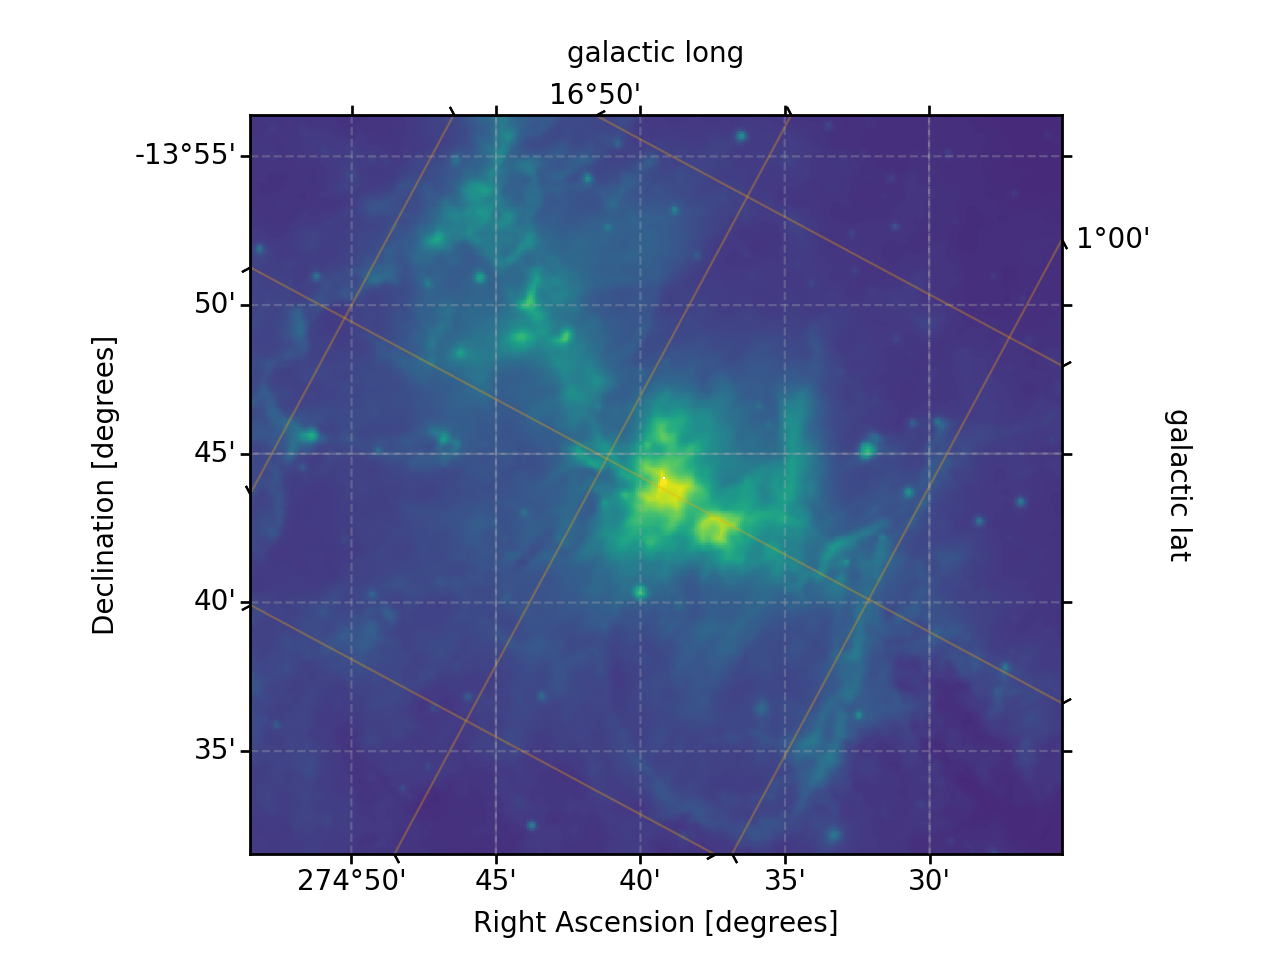

In [137]:
ax = plt.subplot(projection=wcs)
ax.imshow(hdulist[0].data)
ax.set_xlabel("Right Ascension [degrees]")
ax.set_ylabel("Declination [degrees]")
ax.coords.grid(grid_type='contours', alpha = 0.3, linestyle='dashed')
overlay = ax.get_coords_overlay('galactic')
overlay[0].set_axislabel('galactic long')
overlay[1].set_axislabel('galactic lat')
overlay.grid(color='orange', alpha=0.3)


## Part 2: Retrieving and investigating the catalog data

### Challenge

The [astroquery](https://astroquery.readthedocs.io/en/latest/) package has an interface to the [Infrared Science Archive (IRSA)](https://irsa.ipac.caltech.edu/frontpage/) which is a large archive of many infrared datasets. One of these datasets is a Galactic plane survey from the MSX satellite.

1. Use astroquery to find out what catalogs are available from IRSA. For each catalog, you'll likely find out a short name (e.g. ``akari_fis`` and a longer name, e.g. ``Akari/FIS Bright Source Catalogue``). Find out what catalogs are available for MSX. [Hint: you can search for ``MSX`` or ``Midcourse`` in the long name - and bonus points if you don't do that by hand!]. Keep track of the short name for the catalog that doesn't contain rejected sources (this will make sense once you see the available catalogs)
1. Next up, do a 'box' search at the position of M16, with a size of 1 degree, from the main MSX catalog. You may run into an issue where there are too many rows being returned (see [here](https://astroquery.readthedocs.io/en/latest/irsa/irsa.html#other-configurations) for information on getting around this issue). How many rows did the query return?
1. Make a scatter plot of the positions of the sources on the sky using their Right Ascension and Declination.
1. The table includes columns called ``q_a`` and ``q_c`` that give the quality of the photometry in bands A and C (where 2 and above is good). Filter the table to include only rows where these two values are greater or equal to 2. How many rows remain? You can try and update your plot of the positions.
1. The ``a``, ``c``, ``d``, and ``e`` bands give the fluxes at 3.4, 4.6, 12, and 22µm respectively. Split the table into two sets of sources: those that have $c/a > 1.5$, and the remaining sources. Next up, plot the positions of each set of sources and compare their distributions.
1. Write a Python script that contains a function that given the parameters for the astroquery search (position and width), will return the two groups of sources for the MSX catalog, and share this function with your co-worker (ideally via a shared git repository!).

In [49]:
[x*3 for x in range(5)]

[0, 3, 6, 9, 12]

In [62]:
[k for k in keys if k.startswith('msx')]

['msxc6', 'msxc6_rej']

In [60]:
{k: v for (k, v) in catalog.items() if k.startswith('msx')}

{'msxc6': 'The Midcourse Space Experiment (MSXC6)',
 'msxc6_rej': 'The Midcourse Space Experiment (MSXC6) Rejects'}

In [108]:
from astroquery.irsa import Irsa
import astropy.units as u

Irsa.ROW_LIMIT = 1000

catalog = Irsa.list_catalogs()
print(type(catalog))
keys = catalog.keys()
print(catalog['msxc6'])
msxCat = catalog['msxc6']
#Irsa.query_region?
#catalog[catalog=='MSX']

<class 'dict'>
The Midcourse Space Experiment (MSXC6)


In [106]:
result = Irsa.query_region('M16', catalog = "msxc6", spatial='Box', width = 1*u.deg)

## Part 3: visualizing the image and catalog together

In [111]:
result

name,ra,dec,clon,clat,epos,xpos,pospa,nscan,b1,q_b1,e_b1,b1snim,b1snpsx,o_b1,b1var,b2,q_b2,e_b2,b2snim,b2snpsx,o_b2,b2var,a,q_a,e_a,asnim,asnpsx,o_a,avar,c,q_c,e_c,csnim,csnpsx,o_c,cvar,d,q_d,e_d,dsnim,dsnpsx,o_d,dvar,e,q_e,e_e,esnim,esnpsx,o_e,evar,varb1,varb2,vara,varc,vard,vare,confb1,confb2,confa,confc,confd,confe,relb1,relb2,rela,relc,reld,rele,id
,deg,deg,,,arcs,arcs,deg,,Jy,,%,,,,,Jy,,%,,,,,Jy,,%,,,,,Jy,,%,,,,,Jy,,%,,,,,Jy,,%,,,,,,,,,,,,,,,,,,,,,,,
object,float64,float64,object,object,float64,float64,float64,int32,float64,int32,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,int32,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,object
G016.9161+00.6737,274.790,-13.897,18h19m09.65s,-13d53m47.76s,2.0,2.4,28.2,2,-17.68,0,-99.0,0.8,-99.0,0,-99.0,-9.5451,0,-99.0,1.1,-99.0,0,-99.0,0.1894,3,5.8,8.8,3.9,2,2.4,1.1414,1,48.7,2.3,2.1,1,-99.0,-0.68222,0,-99.0,0.8,-99.0,0,-99.0,-2.1173,0,-99.0,-999.0,-99.0,0,-99.0,0,0,0,0,0,0,0,0,1,0,0,0,9,9,0,0,9,9,0
G016.8409+01.0710,274.393,-13.775,18h17m34.37s,-13d46m28.92s,0.3,0.3,28.3,3,-14.561,0,-99.0,1.2,-99.0,0,-99.0,-7.8616,0,-99.0,2.4,-99.0,0,-99.0,7.273,4,4.1,302.8,158.5,3,0.3,10.474,4,5.0,48.7,16.3,3,2.4,8.4727,4,6.1,49.6,20.6,3,1.4,6.7457,4,6.1,15.6,8.9,3,2.3,0,0,0,0,0,0,0,0,0,0,0,0,9,9,0,0,0,0,1
G017.2968+00.9489,274.726,-13.431,18h18m54.19s,-13d25m51.96s,0.3,0.3,28.2,4,-11.464,0,-99.0,1.2,-99.0,0,-99.0,-6.1894,0,-99.0,1.3,-99.0,0,-99.0,3.5012,4,4.1,145.9,84.8,3,0.4,3.9683,4,5.3,17.6,7.1,4,1.8,2.9911,4,6.3,16.7,7.2,3,0.7,-1.262,0,-99.0,2.1,-99.0,0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,0,0,0,9,2
G016.4082+00.9962,274.249,-14.191,18h16m59.86s,-14d11m27.96s,0.3,0.3,28.3,3,-14.561,0,-99.0,1.0,-99.0,0,-99.0,-7.8616,0,-99.0,1.3,-99.0,0,-99.0,3.6601,4,4.1,177.2,83.1,3,0.5,4.6378,4,5.2,23.9,8.1,3,1.4,3.6002,4,6.2,23.4,9.0,3,0.8,2.3566,2,6.9,6.0,4.2,2,0.5,0,0,0,0,0,0,0,0,0,0,0,0,9,9,0,0,0,0,3
G017.4659+00.8495,274.898,-13.329,18h19m35.52s,-13d19m44.40s,0.3,0.4,28.2,3,-13.238,0,-99.0,0.6,-99.0,0,-99.0,12.529,1,40.2,2.1,2.6,1,-99.0,2.0548,4,4.1,89.8,52.4,3,0.8,2.1415,3,6.0,9.8,3.7,3,2.9,1.5677,3,6.9,9.0,4.3,3,0.8,2.2669,1,38.1,2.9,2.7,1,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,4
G017.0045+00.8188,274.702,-13.750,18h18m48.38s,-13d45m00.36s,0.3,0.4,28.2,3,-13.238,0,-99.0,0.8,-99.0,0,-99.0,-7.1469,0,-99.0,1.6,-99.0,0,-99.0,1.9297,4,4.1,80.4,47.1,3,0.4,3.3698,4,5.4,14.8,6.4,3,0.4,1.0968,2,7.6,6.1,2.8,1,-99.0,-1.4573,0,-99.0,2.2,-99.0,0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,2,0,0,9,5
G016.9436+00.7547,274.730,-13.834,18h18m55.22s,-13d50m02.76s,0.3,0.4,28.2,3,-13.238,0,-99.0,0.2,-99.0,0,-99.0,-7.1469,0,-99.0,1.3,-99.0,0,-99.0,2.4053,4,4.1,97.3,45.3,3,0.5,4.4706,4,5.3,19.2,6.5,3,1.3,1.5203,3,6.9,8.2,4.4,3,2.9,2.4361,2,7.1,5.1,4.4,1,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,1,0,0,0,6
G016.9338+00.9157,274.579,-13.767,18h18m19.03s,-13d45m59.76s,0.9,0.9,28.1,4,-11.464,0,-99.0,1.0,-99.0,0,-99.0,-6.1894,0,-99.0,1.3,-99.0,0,-99.0,0.24087,4,5.0,12.0,3.3,3,3.0,0.80218,1,8.9,4.1,-99.0,-1,-99.0,2.7779,4,6.3,17.6,6.8,2,0.4,7.8532,4,6.1,19.4,-99.0,-1,-99.0,0,0,1,0,0,0,0,0,0,0,0,0,9,9,0,0,0,0,7


In [135]:
import numpy as np

ras = result['ra']
decs = result['dec']


q_as = result['q_a']
q_cs = result['q_c']



q_as[(q_as >= 2) & (q_cs >=2)]

ras_limit = ras[(q_as >= 2) & (q_cs >=2)]
decs_limit = decs[(q_as >= 2) & (q_cs >=2)]




<IPython.core.display.Javascript object>


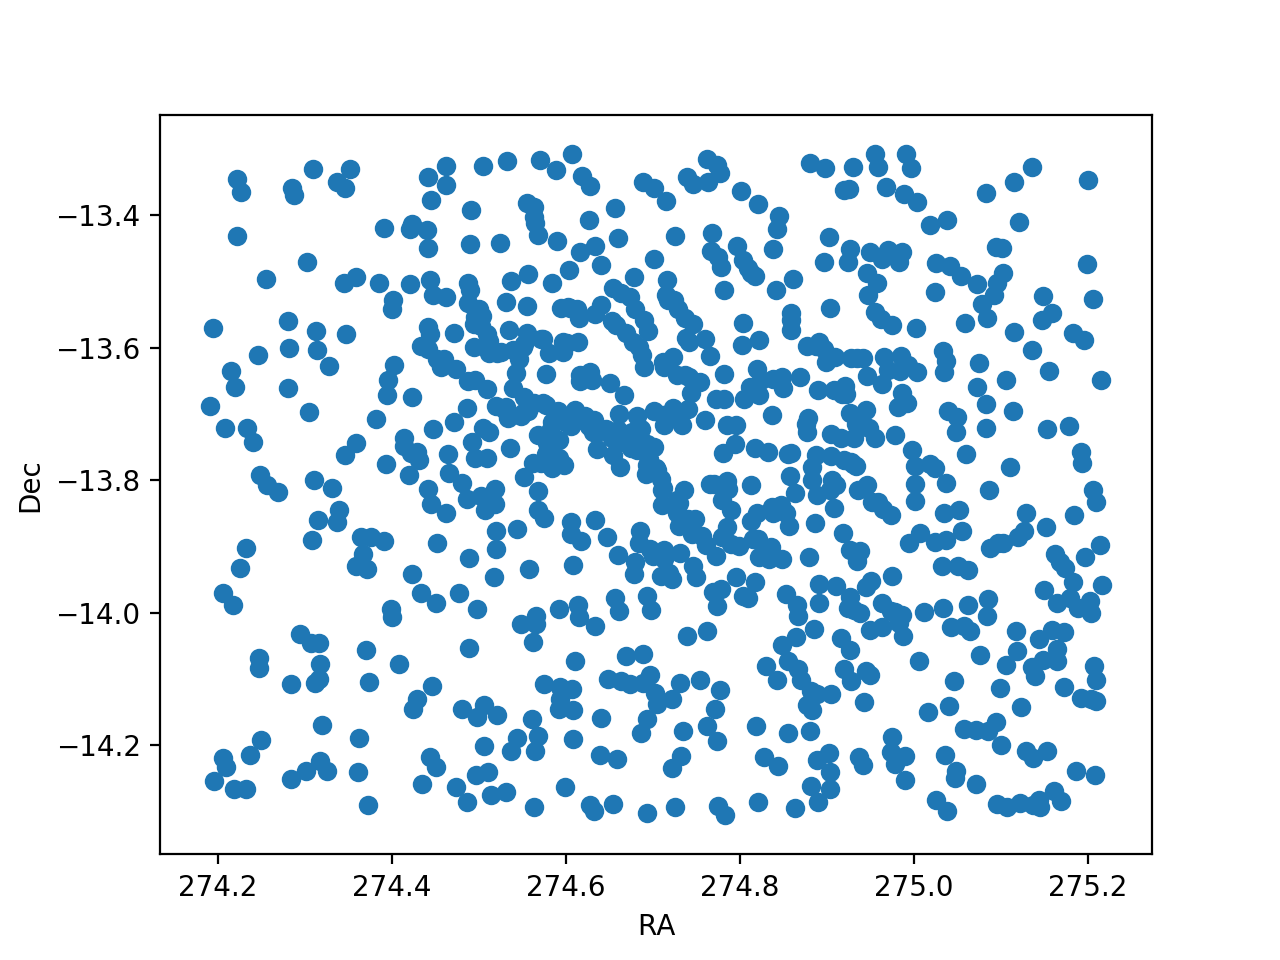

Text(0,0.5,'Dec')

In [116]:
fig = plt.figure()

plt.scatter(ras, decs)
plt.xlabel('RA')
plt.ylabel('Dec')

<IPython.core.display.Javascript object>


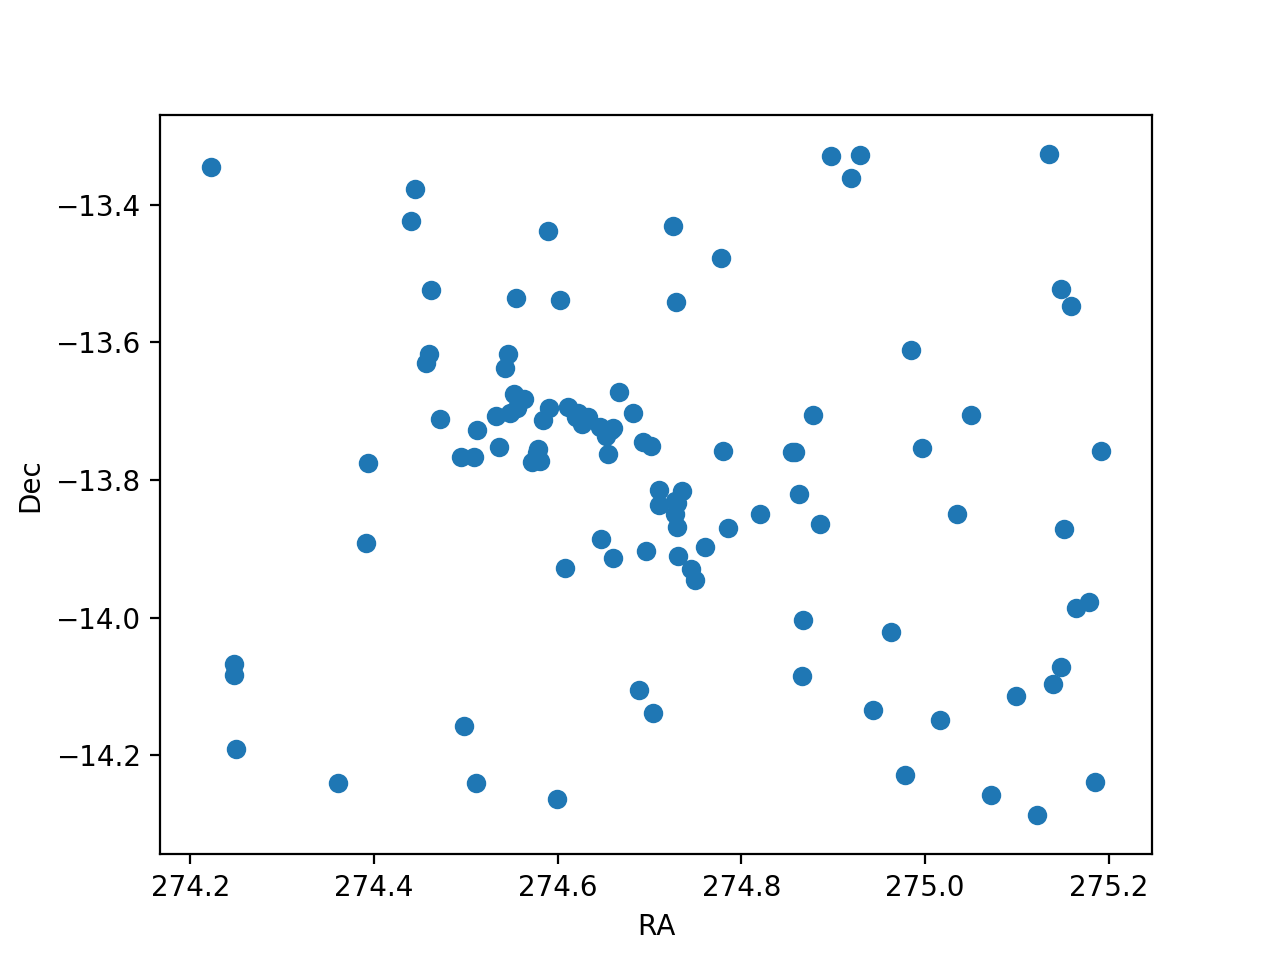

Text(0,0.5,'Dec')

In [136]:
fig = plt.figure()

plt.scatter(ras_limit, decs_limit)
plt.xlabel('RA')
plt.ylabel('Dec')

### Challange

For this part, you can each do this on your computer by starting from the two functions written in Parts 1 and 2. If you need help on figuring out how to share the functions and using them in a notebook, ask your instructors!

1. Work together to find a way to overlay the two sets of sources found in Part 2.5 on top of the image, using different color-coding. There are different ways of doing this, but if you are short on time and need a hint, [click here](http://docs.astropy.org/en/latest/api/astropy.visualization.wcsaxes.WCSAxes.html?highlight=plot_coord#astropy.visualization.wcsaxes.WCSAxes.plot_coord) for one of the possibilities.
1. If you still have time remaining, try making a histogram of the pixel values in the image at the location of each set of points, and find out whether one of the sets of points is correlated with higher values of the flux in the image.